In [1]:
import lib.functions0 as f0
import numpy as np
from scipy.linalg import expm
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
from sympy import Matrix
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

## IBM open-science-prize-2021/22 solution. By Quantum Polo Gang: Ruben, Fabio & Valerio

## Decomposition:
- We computed numerically the operator of N trotter steps, for a certain evolution time: $U^n$
- Observing that this operator preserves the magnetization of the system, if the initial state belongs to an eigenspace of the magnetization is possible to decompose the operator with 4 c-not. If the initial state is a superposition of states with different magnetization the best decomposition we found has 11 c-not (14 for the Jakarta geometry).
- Our initial state is $|110>$ (qubits 5,3 and 1 respectively) so we can use the best decomposition (4 c-not).

To see the decomposition procedure open  *decomposition.ipynb* file.

Let's start from defining the evolution circuit parameters, and computing the evolution matrix (which will be decomposed into a circuit):

- *steps*: number of trotter steps (integer).
- *time*: time of evolution (float).
- *initial_state*: the 3-qubit initial state (string): from right to left, associated with qubits 1, 3 and 5 respectively
- *shots*: number of shots for every run.
- *backend*: here you can choose on which backend run the simulation: *backend_sim_jakarta* (noisy simulator), *backend_real_jakarta* (real device), *backend_sim* (simulator)

In [2]:
n_steps=51
time=np.pi
initial_state={"110": 1}
shots = 80
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                     0,                     0,                     0,                     0,                     0,                     0,   0],
[  0,       1.0 + 0.00395*I,  0.000758 + 0.00395*I,                     0, -0.000711 - 0.00791*I,                     0,                     0,   0],
[  0, -0.000711 + 0.00395*I,       1.0 - 0.00791*I,                     0,  0.000758 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,       1.0 + 0.00395*I,                     0, -0.000711 + 0.00395*I,  0.000758 - 0.00791*I,   0],
[  0,  0.000758 - 0.00791*I, -0.000711 + 0.00395*I,                     0,       1.0 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,  0.000758 + 0.00395*I,                     0,       1.0 - 0.00791*I, -0.000711 + 0.00395*I,   0],
[  0,                     0,                     0, -0.000711 - 0.00791*I,                 

# Single State Decomposition

This Decomposition works only in a symmetry preserving subspace of the Hamiltonian. In this case we are in the magnetization m=2 subspace.

We need to find a $U_{best}$ gate for which $T_{step}^{n}|110>=U_{best}|110>$, and reduces the depth of the circuit.
If the initial state is a vector of the computational basis this decomposition coincides with the preparation of a specific column of the matrix, in this case the 7th column. 

The idea is to find a generic circuit that preserves the symmetry and dependes on 2d real parameters, where d is the dimension of the subspace.  
Instead of repeating the Trotter Step we numerically calculate $T_{step}^{n}$ and find the parameters of the optimizated circuit. In this case we need at least a six parameters circuit.

Cause of our trotterized operator preserves the magnetizaione, we supposed that $U_{best}$ should be in the following form:

$$U_{best}=(I \otimes M_{2}(f_2,r_2,a_2))(M_{1}(f_1,r_1,a_1) \otimes I)$$

where $M_{1}$ and $M_{2}$ are two-qubits gates that preserve the magnetization of the inizial state.


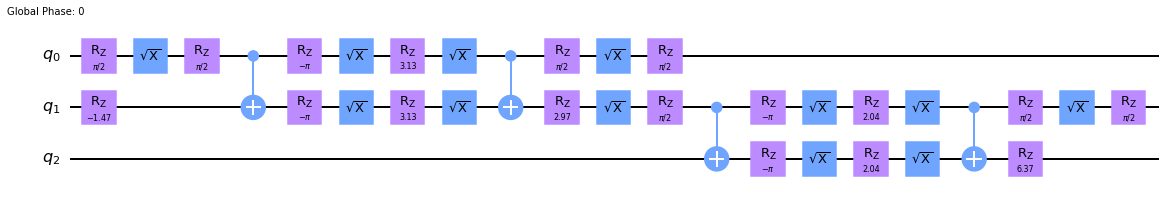

In [3]:
phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = f0.get_gates_parameters(trotterized, initial_state={"110": 1.0})

# Assembles the parametric 2-qubit circuits
M1_qc = f0.fixed_magnetization_two_qubit_gate(phase_1_1,phase_1_2,a1)
M2_qc = f0.fixed_magnetization_two_qubit_gate(phase_2_1,phase_2_2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

# Ancillas Mitigation

Our first approach to mitigation consists in using the ancillas to check if the state is in the right magnetization, just before changing the tomography base and measuring. We measure the ancillas and if them belong to the wrong magnetization subspace we delete that measure, because we are sure there was an error.

To see more details open *Ancillas_Error_mitigation_Git_Hub.pynb*.

Here we draw the circuit for the used mitigation:

    - qubits 4, 5 and 6 are the "evolution qubits".
    - qubits 0, 1, 2 and 3 are the ancillas.

You can see that the evolution qubits act as control qubits on the ancillas, so they don't change during the execution.

In [4]:
qc_check=f0.symmetry_check(type="4copy_check")
qc_check.draw(output="mpl")

NameError: name 'symmetry_check' is not defined

So we add it to the circuit

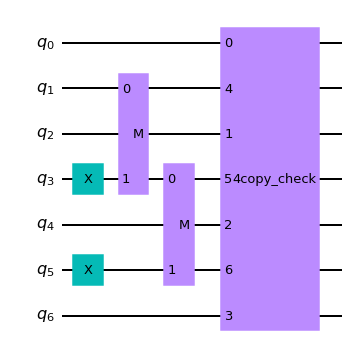

In [ ]:
qc = f0.add_symmetry_check(qc, [qr[1],qr[3],qr[5]], [qr[0],qr[2],qr[4],qr[6]], type="4copy_check")
qc.draw(output="mpl")

Then, we build the tomography circuits

In [5]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

qcs = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]])
qcs_na = state_tomography_circuits(qc, [qr[1],qr[3],qr[5]])

## add the measure on the ancillas

for qc in qcs:
    cr_anc = ClassicalRegister(4)
    qc.add_register(cr_anc)
    #qc.barrier()
    qc.measure([0,2,4,6],cr_anc)

## qcs_tot is a list holding the tomography cirquits reps times.

qcs_tot = []
for _ in range(reps):
    qcs_tot=qcs_tot + qcs

qcs[10].draw(output="mpl")

NameError: name 'qc' is not defined

nice, now we have the evolution cirquits, so, let us expolain how we build the calibration circuits.

# Measure and noise mitigation.

In [ ]:
qcs_calibs, meas_calibs = calibration_cirquits("column_evolution_remake", q_anc=[0,2,4,6], check="yes", check_type="4copy_check")
state_lables = bin_list(7)

In [ ]:
state_lables[0]

'0000000'

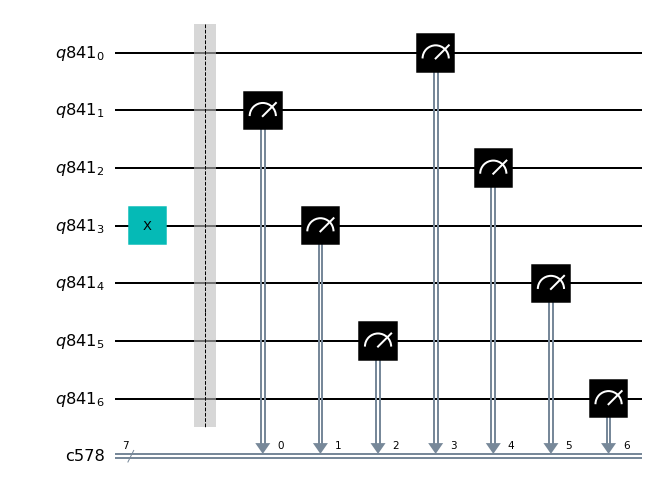

In [ ]:
meas_calibs[2].draw(output="mpl")

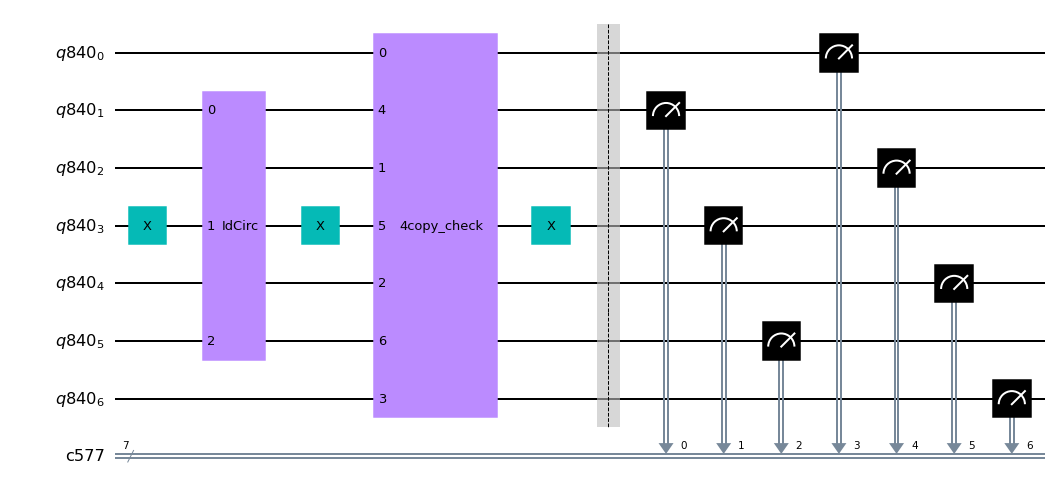

In [ ]:
qcs_calibs[2].draw(output="mpl")

Than we run all the circuits

In [ ]:
jobs_evo=execute(qcs_tot, backend=backend, shots=shots)
job_cal_our=execute(qcs_calibs, backend=backend, shots=shots)
job_cal=execute(meas_calibs, backend=backend, shots=shots)

NameError: name 'qcs_tot' is not defined

In [ ]:
jobs_evo_result = jobs_result(job_evolution = jobs_evo, reps = reps, ancillas=[0,2,4,6])

or we can retrieve the jobs

In [ ]:
#evo_ID = "6233ae39d97bff04d66929e9"
#cal_ID = "6233ae3ba2f72dff43da994f"

#evo_job=backend.retrieve_job(evo_ID)
#job_cal_our=backend.retrieve_job(cal_ID)
'''
reps=8
steps=42
backend=backend_real_jakarta

job_cal_our =backend.retrieve_job("6237aee18293e9eb4e1e4c4a")
job_cal =backend.retrieve_job("6237aedf0af65dc88cd92302")

job=backend.jobs(limit=30, start_datetime= "2022-03-19", end_datetime="2022-03-26")[2]

jobs_evo_result = jobs_result(job_evolution = job, reps = reps, ancillas=[0,2,4,6])
'''

In [ ]:
#### DA CANCELLAREEEEEEEEEEEEEEEEEEE
#state_lables = bin_list(7)
#qcs_na = circuits_without_ancillas_measuraments(job)


Next we apply the mitigation in the following way:

- measure mitigation: we apply the inverse of the calibration matrix to each circuit (see *measure_mitigation.ipynb*)
- ancillas mitigation: we throw away all the measures which contain a value for the ancillas physically forbidden.

this is done by the *mitigate* function.

Then we compute the fidelity for both the mitigated results and not-mitigated ones, in order check the gain given by the mitigation.

In [ ]:
meas_fitter_our = CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels=state_lables)


target_state = (One^One^Zero).to_matrix()

fids=np.zeros([reps,4])
fids_mean=np.zeros(4)
fids_dev=np.zeros(4)

for j in range(reps):
    
    res = jobs_evo_result[j]
    print(j)
    new_res, new_res_nm = mitigate(res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter)
    new_res_our, new_res_nm = mitigate(res, Measure_Mitig="yes", ancillas_conditions=['0011','1110','1101'], meas_fitter=meas_fitter_our)
    new_res_not_mitigated = mitigate(res, Measure_Mitig="no", ancillas_conditions=bin_list(4))

    fids[j,0] = fidelity_count(new_res_not_mitigated, qcs_na, target_state)
    fids[j,1] = fidelity_count(new_res_nm, qcs_na, target_state)
    fids[j,2] = fidelity_count(new_res, qcs_na, target_state)
    fids[j,3] = fidelity_count(new_res_our, qcs_na, target_state)

for i in range(4):
    fids_mean[i]=np.mean(fids[:,i])
    fids_dev[i]=np.std(fids[:,i])


In [ ]:
new_res_our.get_counts(-1)

Printing the fidelity

In [ ]:
labels = ["raw:                                       ",
          "ancillas mitigation:                       ",
          "ancillas and qiskit measurement mitigation:",
          "ancillas and our measurement mitigation:   "
]

for i in range(4):
    print(labels[i], fids_mean[i], " +- ", fids_dev[i])